# Utilisation de bigml pour créer des modèles d'apprentissage

In [106]:
from pandas import DataFrame, read_csv, Series
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from bigml.api import BigML
api = BigML(project="project/5d94a42042129f2b0500005c")

## Importation des dataframe depuis les fichiers générés précédemment

In [2]:
df = read_csv('fulltrain_mod.csv')
df2 = read_csv('test_mod.csv')

## Création des sources et datasets correspondants du fichier trainfull sur le site bigml

In [3]:
source_args = {"name": "171007 fulltrain ipnb",
     "source_parser": {"missing_tokens": ["NULL"]}}
source = api.create_source('fulltrain_mod.csv', source_args)

dataset_args = {"name": "171007 ipnb trainfull"}
dataset = api.create_dataset(source, dataset_args)

KeyboardInterrupt: 

## Création du split trainfull en 80/20 pour train/test

In [ ]:
train_dataset = api.create_dataset(
    dataset, {"name": "171007 ipnb - Train",
                     "sample_rate": 0.8, "seed": "my_seed"})

val_dataset = api.create_dataset(
    dataset, {"name": "171007 ipnb - Validation",
                     "sample_rate": 0.8, "seed": "my_seed", "out_of_bag": True})

# Génération du modèle d'apprentissage

In [ ]:
model_args = {"objective_field": "SeriousDlqin2yrs"}
model = api.create_ensemble(train_dataset, model_args)

In [ ]:
api.ok(model)

In [ ]:
model = api.get_ensemble(model)

In [ ]:
api.pprint(model['object']['ensemble'])

# Evaluation du modèle (AUC, matrice de confusion, ...)

In [ ]:
evaluation = api.create_evaluation(model, val_dataset, {
    "name": "171007 ipnb - Train - evaluation"})

## Récupérer des données existantes sur bigml

In [107]:
model = api.get_ensemble("ensemble/5db162ae7811dd0557000e0e")
val_dataset = api.get_dataset("dataset/5db162955299631c82008bd0")
evaluation = api.get_evaluation("evaluation/5db162d07811dd7f2d00872a")

## Matrice de confusion

In [108]:
api.pprint(evaluation['object']['result']['model']['confusion_matrix'])

[[27739, 223], [1711, 327]]


## Critère de performance ROC AUC

In [109]:
api.pprint(evaluation['object']['result']['model']['per_class_statistics'][0]['area_under_roc_curve'])

0.85905


# Génération de la prédiction sur le 20% validation

In [ ]:
prediction_args = {"name": "171007 ipnb - Train (80%) - 20% Prediction",
                  "header": True,
                  "probabilities": True,
                  "all_fields": True}

batch_prediction = api.create_batch_prediction(model, val_dataset, prediction_args)

In [ ]:
api.ok(batch_prediction)

## Téléchargement du fichier de prédiction

In [2]:
api.download_batch_prediction(batch_prediction,
                              filename= "171007 ipnb 80% - val prediction.csv")

NameError: name 'batch_prediction' is not defined

In [287]:
df4 = read_csv('171007 ipnb 80% - val prediction.csv')
df4

,field1,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyIncome_sansna,Sum,IncomePerPerson,SeriousDlqin2yrs.1,0 probability,1 probability
0,9,10,0,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0,23684,0,7894.666667,0,0.97277,0.02723
1,11,12,0,0.018798,51,0,0.531529,6501.0,7,0,2,0,2.0,6501,0,2167.000000,0,0.98023,0.01977
2,20,21,0,0.200923,43,0,0.430046,12300.0,10,0,2,0,0.0,12300,0,12300.000000,0,0.98885,0.01115
3,42,43,0,0.469057,31,0,0.048211,9250.0,4,0,0,0,1.0,9250,0,4625.000000,0,0.96847,0.03153
4,49,50,0,0.000080,70,0,0.256340,6900.0,21,1,1,0,0.0,6900,1,6900.000000,0,0.85043,0.14957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,149977,149978,0,0.236450,29,0,349.000000,NaN,3,0,0,0,0.0,0,0,NaN,0,0.98429,0.01571
29996,149982,149983,0,0.021046,37,0,0.250272,2760.0,8,0,0,0,3.0,2760,0,690.000000,0,0.98963,0.01037
29997,149986,149987,0,0.168102,49,0,0.080384,5000.0,16,0,0,0,1.0,5000,0,2500.000000,0,0.96253,0.03747
29998,149988,149989,0,0.902051,31,1,0.347924,7515.0,10,0,1,0,0.0,7515,1,7515.000000,0,0.87037,0.12963


# Evaluation du modèle

## Calcul matrice de confusion à la main

In [288]:
Preal = df4['SeriousDlqin2yrs'] == 1
Nreal = df4['SeriousDlqin2yrs'] == 0
Ppred = df4['SeriousDlqin2yrs.1'] == 1
Npred = df4['SeriousDlqin2yrs.1'] == 0
df4.loc[Ppred & Preal, 'Eval'] = 'TP'
df4.loc[Ppred & Nreal, 'Eval'] = 'FP'
df4.loc[Npred & Nreal, 'Eval'] = 'TN'
df4.loc[Npred & Preal, 'Eval'] = 'FN'
df4

,field1,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyIncome_sansna,Sum,IncomePerPerson,SeriousDlqin2yrs.1,0 probability,1 probability,Eval
0,9,10,0,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0,23684,0,7894.666667,0,0.97277,0.02723,TN
1,11,12,0,0.018798,51,0,0.531529,6501.0,7,0,2,0,2.0,6501,0,2167.000000,0,0.98023,0.01977,TN
2,20,21,0,0.200923,43,0,0.430046,12300.0,10,0,2,0,0.0,12300,0,12300.000000,0,0.98885,0.01115,TN
3,42,43,0,0.469057,31,0,0.048211,9250.0,4,0,0,0,1.0,9250,0,4625.000000,0,0.96847,0.03153,TN
4,49,50,0,0.000080,70,0,0.256340,6900.0,21,1,1,0,0.0,6900,1,6900.000000,0,0.85043,0.14957,TN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,149977,149978,0,0.236450,29,0,349.000000,NaN,3,0,0,0,0.0,0,0,NaN,0,0.98429,0.01571,TN
29996,149982,149983,0,0.021046,37,0,0.250272,2760.0,8,0,0,0,3.0,2760,0,690.000000,0,0.98963,0.01037,TN
29997,149986,149987,0,0.168102,49,0,0.080384,5000.0,16,0,0,0,1.0,5000,0,2500.000000,0,0.96253,0.03747,TN
29998,149988,149989,0,0.902051,31,1,0.347924,7515.0,10,0,1,0,0.0,7515,1,7515.000000,0,0.87037,0.12963,TN


In [289]:
df4[['field1','Eval']].groupby('Eval').count()

,field1
Eval,
FN,1711
FP,223
TN,27739
TP,327


In [290]:
confusion_matrix = df4['Eval'].value_counts()
confusion_matrix

TN    27739
FN     1711
TP      327
FP      223
Name: Eval, dtype: int64

```python
df4['bigerror'] = (df4['1 probability'] - df4['SeriousDlqin2yrs'])
df4.sort_values('bigerror', ascending=False)[:10]```

In [291]:
df4['bigerror'] = (df4['1 probability'] - df4['SeriousDlqin2yrs'])
df4.sort_values('bigerror', ascending=False)[:10]

,field1,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,...,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyIncome_sansna,Sum,IncomePerPerson,SeriousDlqin2yrs.1,0 probability,1 probability,Eval,bigerror
23063,116003,116004,0,1.680710,51,1,0.178730,3384.0,7,2,...,3,1.0,3384,6,1692.0,1,0.23892,0.76108,FP,0.76108
8711,43704,43705,0,1.455090,35,2,0.065604,3200.0,3,6,...,1,1.0,3200,9,1600.0,1,0.26332,0.73668,FP,0.73668
3626,18633,18634,0,1.671105,52,3,0.513251,4527.0,8,3,...,1,4.0,4527,7,905.4,1,0.26670,0.73330,FP,0.73330
17902,89939,89940,0,0.874335,49,4,2146.000000,NaN,9,4,...,0,0.0,0,8,NaN,1,0.27535,0.72465,FP,0.72465
29838,149206,149207,0,0.465183,51,3,2824.000000,NaN,7,2,...,4,0.0,0,9,NaN,1,0.27698,0.72303,FP,0.72303
5390,27476,27477,0,1.000000,72,98,0.004888,4500.0,0,98,...,98,0.0,4500,294,4500.0,1,0.27867,0.72133,FP,0.72133
26256,131688,131689,0,1.212625,36,1,0.356739,3004.0,5,4,...,2,1.0,3004,7,1502.0,1,0.27884,0.72116,FP,0.72116
23887,120049,120050,0,1.000000,46,96,0.051765,4616.0,0,96,...,96,0.0,4616,288,4616.0,1,0.27894,0.72106,FP,0.72106
24201,121572,121573,0,1.389805,44,5,126.000000,NaN,2,3,...,1,0.0,0,9,NaN,1,0.28080,0.71920,FP,0.71920
28999,145149,145150,0,1.000000,36,3,3539.000000,NaN,4,2,...,1,1.0,0,6,NaN,1,0.28223,0.71778,FP,0.71778


## Calcul du gain

In [292]:
matrix_cost = Series([0, -500, 500, -2500], index = ['TP', 'FP', 'TN', 'FN'])
matrix_cost

TP       0
FP    -500
TN     500
FN   -2500
dtype: int64

In [293]:
matrix_gain = confusion_matrix * matrix_cost
matrix_gain

FN    -4277500
FP     -111500
TN    13869500
TP           0
dtype: int64

In [294]:
matrix_gain.sum()

9480500

## Calcul avec plusieurs niveaux de seuil

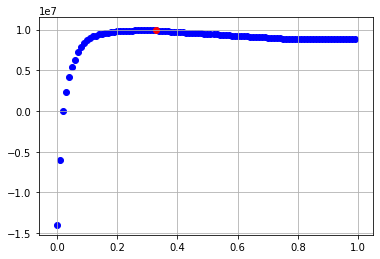

9909000 0.33


In [296]:
best_seuil = 0
best_gain = 0
fig = plt.figure()
line, = plt.plot([], [], "b")
for i in range(0,100):
    seuil = i/100
    Ppred = df4['1 probability'] >= seuil
    Npred = df4['1 probability'] < seuil
    df4.loc[Ppred & Preal, 'Eval2'] = 'TP'
    df4.loc[Ppred & Nreal, 'Eval2'] = 'FP'
    df4.loc[Npred & Nreal, 'Eval2'] = 'TN'
    df4.loc[Npred & Preal, 'Eval2'] = 'FN'
    confusion_matrix = Series(0, index = ['TP', 'FP', 'TN', 'FN'])
    confusion_matrix = confusion_matrix + df4['Eval2'].value_counts()
    confusion_matrix.fillna(0, inplace=True)
    total_gain = -500*confusion_matrix.loc['FP'] + 0*confusion_matrix.loc['TP'] - 2500*confusion_matrix.loc['FN'] + 500*confusion_matrix.loc['TN']
    plt.scatter(seuil, total_gain, c='blue')
    if total_gain > best_gain:
        best_gain = total_gain
        best_seuil = seuil

plt.scatter(best_seuil, best_gain, c='red')
plt.grid(True)
plt.show()
print(best_gain, best_seuil)

## Tri des données pour préparer le calcul de AUC manuel

In [297]:
df4_sorted = df4.sort_values('1 probability', ascending=False)
df4_sorted

,field1,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,...,NumberOfDependents,MonthlyIncome_sansna,Sum,IncomePerPerson,SeriousDlqin2yrs.1,0 probability,1 probability,Eval,bigerror,Eval2
28835,144294,144295,1,1.640719,42,2,0.382642,6820.0,3,6,...,0.0,6820,8,6820.0,1,0.23133,0.76867,TP,-0.23133,FN
5403,27563,27564,1,1.396226,37,3,3506.000000,NaN,10,4,...,4.0,0,11,NaN,1,0.23450,0.76550,TP,-0.23450,FN
23063,116003,116004,0,1.680710,51,1,0.178730,3384.0,7,2,...,1.0,3384,6,1692.0,1,0.23892,0.76108,FP,0.76108,TN
14794,74423,74424,1,1.000000,64,1,1560.000000,NaN,3,3,...,0.0,0,6,NaN,1,0.24078,0.75922,TP,-0.24078,FN
28444,142357,142358,1,2.297612,42,1,0.806048,4000.0,8,2,...,0.0,4000,7,4000.0,1,0.24990,0.75010,TP,-0.24990,FN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7423,37459,37460,0,0.001243,84,0,0.000125,8020.0,5,0,...,0.0,8020,0,8020.0,0,0.99835,0.00165,TN,0.00165,TN
15714,79049,79050,0,0.010199,93,0,0.000720,8333.0,5,0,...,0.0,8333,0,8333.0,0,0.99835,0.00165,TN,0.00165,TN
3624,18626,18627,0,0.008639,84,0,0.008125,7630.0,3,0,...,0.0,7630,0,7630.0,0,0.99835,0.00165,TN,0.00165,TN
22224,111621,111622,0,0.091588,81,0,0.004761,10500.0,4,0,...,0.0,10500,0,10500.0,0,0.99851,0.00149,TN,0.00149,TN


### Calcul de la somme des négatifs en dessous de chaque positifs (1 probability est inférieur)

In [298]:
%%timeit
N_sum_below = 0
for index in range(len(df4_sorted)):
    if df4_sorted['SeriousDlqin2yrs'].iloc[index] == 1:
        N_sum_below += df4_sorted['SeriousDlqin2yrs'][index+1:].value_counts().loc[0]


2.71 s ± 22.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Calcul du nombre précédent si tous les négatifs étaient en dessous des positifs

In [102]:
N_number = df4_sorted['SeriousDlqin2yrs'].value_counts().loc[0]
P_number  = df4_sorted['SeriousDlqin2yrs'].value_counts().loc[1]
NP_product = N_number * P_number
print (N_number, P_number, NP_product)

27962 2038 56986556


### Calcul de l'AUC

In [103]:
AUC = N_sum_below / NP_product
AUC

0.8590172917275436

### Autre technique (maud)

In [284]:
%%timeit
auc = 0
P_cumul = 0
for i in range(len(df4_sorted['SeriousDlqin2yrs'])):
    if df4_sorted['SeriousDlqin2yrs'].values[i] == 1:
        P_cumul += 1
    else:
        auc += P_cumul
        
auc = auc/NP_product

143 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [283]:
auc

0.8590172917275436

## Récupération des importances des features pour refaire le "summary report"

In [172]:
importances = model['object']['importance']
importances

{'000001': 0.02988,
 '000003': 0.22704,
 '000004': 0.11247,
 '000005': 0.01248,
 '000006': 0.03489,
 '000007': 0.03715,
 '000008': 0.09525,
 '000009': 0.04545,
 '00000a': 0.06063,
 '00000b': 0.0126,
 '00000c': 0.0117,
 '00000d': 0.03555,
 '00000e': 0.24773,
 '00000f': 0.03719}

### Récupération des noms de colonnes correspondant

In [299]:
importances_named = dict()
for column, importance in importances.items():
    column_name = model['object']['ensemble']['fields'][column]['name']
    importances_named[column_name] = [importance*100]

importances_named

{'Unnamed: 0': 2.988,
 'RevolvingUtilizationOfUnsecuredLines': 22.704,
 'age': 11.247,
 'NumberOfTime30-59DaysPastDueNotWorse': 1.248,
 'DebtRatio': 3.489,
 'MonthlyIncome': 3.7150000000000003,
 'NumberOfOpenCreditLinesAndLoans': 9.525,
 'NumberOfTimes90DaysLate': 4.545,
 'NumberRealEstateLoansOrLines': 6.063000000000001,
 'NumberOfTime60-89DaysPastDueNotWorse': 1.26,
 'NumberOfDependents': 1.17,
 'MonthlyIncome_sansna': 3.5549999999999997,
 'Sum': 24.773,
 'IncomePerPerson': 3.7190000000000003}

### Conversion en dataframe

In [269]:
importances_named_df = DataFrame.from_dict(importances_named, orient='index').sort_values(0, ascending=False)
importances_named_df

,0
Sum,24.773
RevolvingUtilizationOfUnsecuredLines,22.704
age,11.247
NumberOfOpenCreditLinesAndLoans,9.525
NumberRealEstateLoansOrLines,6.063
NumberOfTimes90DaysLate,4.545
IncomePerPerson,3.719
MonthlyIncome,3.715
MonthlyIncome_sansna,3.555
DebtRatio,3.489


### Création de l'histogramme

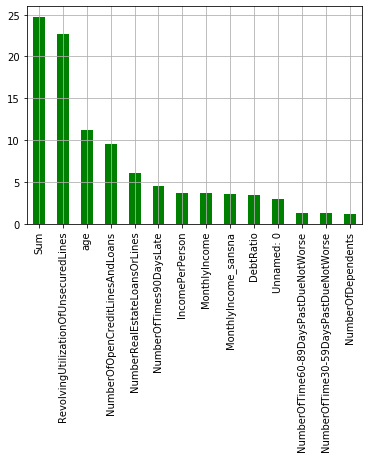

In [270]:
importances_named_df.plot(kind='bar', color='green', legend=False, grid=True);

### Version de l'histogramme à partir du dictionnaire (pas de dataframe)

Text(0.5, 0.98, 'Importance fields')

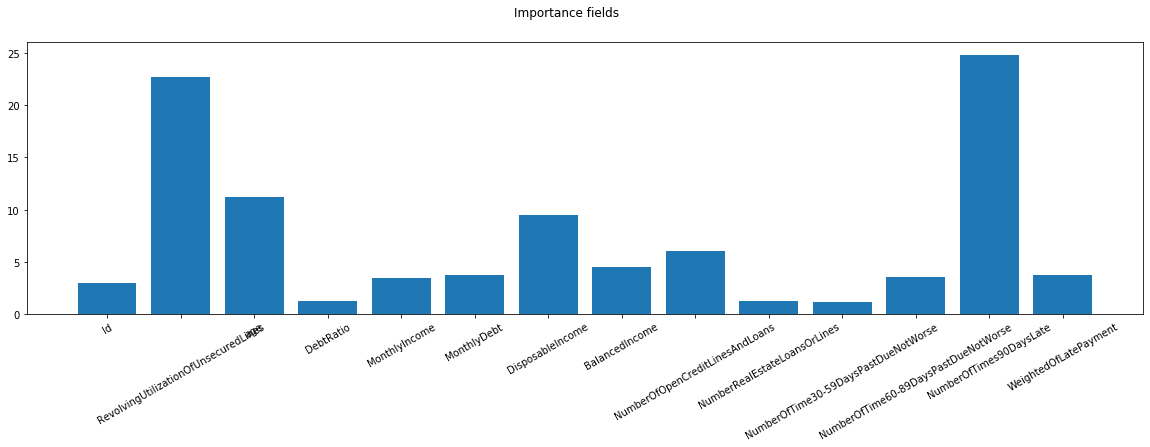

In [301]:
names = list(importances_named.keys())
values = list(importances_named.values())

fig, axs = plt.subplots(figsize=(20, 5), sharey=True)
axs.bar(names, values)

xtick_labels = ['Id','RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio', 'MonthlyIncome', 'MonthlyDebt', 'DisposableIncome', 'BalancedIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'WeightedOfLatePayment', 'NumberOfDependents', 'SeriousDlqin2yrs']
plt.xticks(names, xtick_labels, rotation=30)

fig.suptitle('Importance fields')